In [25]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
import xarray as xr
from pyproj import Geod
from tqdm import tqdm
from damagescanner.core import DamageScanner

#  Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [ ]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"
intermediate_results_path = BASE_DIR / 'intermediate_results'

In [ ]:
gdf_results = gpd.read_parquet(intermediate_results_path / "criticality_results.parquet")

In [28]:
# Load country outline
world_path =  data_path / "ne_10m_admin_0_countries.shp"
world = gpd.read_file(world_path)
country_plot = world.loc[world.SOV_A3 == 'SRB']

# read flood data
flood_path = data_path / "Europe_RP100_filled_depth.tif"

country_bounds = world.loc[world.SOV_A3 == 'SRB'].bounds
country_geom = world.loc[world.SOV_A3 == 'SRB'].geometry

hazard_map = xr.open_dataset(flood_path, engine="rasterio")
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                 miny=country_bounds.miny.values[0],
                 maxx=country_bounds.maxx.values[0],
                 maxy=country_bounds.maxy.values[0]
                ).load()

exposed_roads = DamageScanner(
    hazard_country, 
    gdf_results, 
    curves=pd.DataFrame(), 
    maxdam=pd.DataFrame()
).exposure(asset_type='roads',disable_progress=False)


convert coverage to meters: 100%|██████████| 2193/2193 [00:05<00:00, 413.40it/s]


In [29]:
def flagged_exposed_segments(row):
        return any(val > 0.25 for val in row['values'])

def max_depth(row):
        return np.max(row['values'])

exposed_roads['exposed'] = exposed_roads.progress_apply(flagged_exposed_segments, axis=1)
exposed_roads['max_depth'] =  exposed_roads.progress_apply(max_depth, axis=1)

convert coverage to meters: 100%|██████████| 2193/2193 [00:00<00:00, 101609.61it/s]


In [30]:
gdf_vhl_flooded = gdf_results.merge(exposed_roads.loc[exposed_roads.exposed][['coverage','values','max_depth']],left_index=True,right_index=True)

In [31]:
gdf_vhl_flooded

,from_id,to_id,objectid,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,...,pct_isolated,pct_unaffected,pct_delayed,average_time_disruption,distance_disruption,time_disruption,vhl,coverage,values,max_depth
4,12,13,5.0,A1023,D,IA,A1,A111,petlja Novi Sad sever,A112,...,0.0,99.908283,0.091717,0.057215,2.300461e-04,2.300461e-04,683.146321,"[7.98187616196413, 70.26538601103236, 69.90608...","[0.13600000739097595, 0.7319999933242798, 0.73...",1.663
6,16,17,8.0,A1004,L,IA,A1,A102,petlja Subotica sever,A101,...,0.0,99.656784,0.343216,0.001360,3.768578e-06,3.768578e-06,10.733231,"[88.6440373255492, 88.51560155956756, 88.42867...","[1.0, 0.43799999356269836, 0.4399999976158142,...",1.000
10,20,21,9.0,A1024,L,IA,A1,A112,petlja Novi Sad centar,A111,...,0.0,99.897360,0.102640,0.012194,2.348411e-04,2.348411e-04,145.598159,"[65.32851164404711, 67.4971709839168, 67.11328...","[0.7319999933242798, 0.7310000061988831, 0.828...",1.663
13,25,26,11.0,A1006,L,IA,A1,A103,petlja Subotica istok,A102,...,0.0,98.617475,1.382525,0.000883,5.465659e-05,5.465659e-05,8.662728,[77.13776407862304],[1.0],1.000
23,36,37,15.0,A1009,D,IA,A1,A104,petlja Subotica jug,A105,...,0.0,99.542137,0.457863,0.002592,3.565594e-06,3.565594e-06,31.130705,[91.49012157991058],[1.7929999828338623],1.793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,2139,586,NaN,None,None,None,None,None,None,None,...,0.0,98.888474,1.111526,0.000181,1.457190e-06,1.457190e-06,NaN,"[22.07936762509592, 42.871221152628024]","[2.86299991607666, 1.7630000114440918]",2.863
5425,1951,1952,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,6.658281e-07,6.658281e-07,NaN,[26.97177995912649],[0.8669999837875366],0.867
5426,1920,1396,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,1.062951e-06,1.062951e-06,NaN,[12.763107365551006],[1.3040000200271606],1.304
5427,1927,1924,NaN,None,None,None,None,None,None,None,...,0.0,100.000000,0.000000,NaN,8.303010e-07,8.303010e-07,NaN,"[8.851670706368333, 18.021107571053633]","[1.4160000085830688, 1.3040000200271606]",1.416


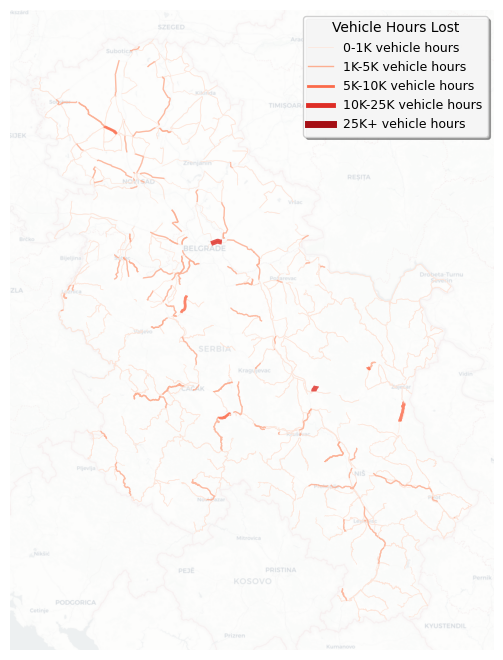

In [32]:
# Define bins based on vehicle hours lost distribution - heavily skewed toward 0
bins = [0, 1000, 5000, 10000, 25000, np.inf]
labels = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']

# Create binned column
gdf_vhl_flooded['vhl_class'] = pd.cut(
    gdf_vhl_flooded['vhl'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Define line widths for each class (higher VHL = thicker lines)
linewidth_map = {
    '0-1K': 0.5,
    '1K-5K': 1.0,
    '5K-10K': 2.0,
    '10K-25K': 3.5,
    '25K+': 5.0
}

# Create a linewidth column
gdf_vhl_flooded['linewidth'] = gdf_vhl_flooded['vhl_class'].map(linewidth_map)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Plot each class separately with both width and color variation
# Using red-orange color progression for impact severity
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']

for i, (class_name, width) in enumerate(linewidth_map.items()):
    subset = gdf_vhl_flooded[gdf_vhl_flooded['vhl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(
            ax=ax,
            color=colors[i],
            linewidth=width,
            alpha=0.8,
            label=class_name
        )

# Add basemap with optimal styling
cx.add_basemap(ax=ax,
    source=cx.providers.CartoDB.Positron,
                alpha=0.4, 
                attribution=False)


# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')

# Create custom legend with line samples that show both width and color
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} vehicle hours')
                  for i, (class_name, width) in enumerate(linewidth_map.items())]

legend = ax.legend(handles=legend_elements, 
                  title='Vehicle Hours Lost', 
                  loc='upper right',
                  fontsize=9,
                  title_fontsize=10,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

# Enhance overall plot appearance
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'vehicle_hours_lost_map_flooded.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
snow_drift = gpd.read_file(data_path / "snezni_nanosi_studije.shp")

c:\Users\yma794\AppData\Local\miniforge3\envs\serbia\Lib\site-packages\pyogrio\raw.py:200: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


In [34]:
gdf_vhl_snowdrift = gdf_results[['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'road_length', 'speed', 'fft','edge_no', 'vhl']].sjoin(snow_drift)

In [35]:
landslides = gpd.read_file(data_path / "Nestabilne_pojave.shp")
landslides.geometry = landslides.geometry.buffer(10)

In [36]:
gdf_vhl_landslides = gdf_results[['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'road_length', 'speed', 'fft','edge_no', 'vhl']].sjoin(landslides)

In [37]:
gdf_vhl_landslides

,from_id,to_id,objectid_left,oznaka_deo_left,smer_gdf1,kategorija_left,oznaka_put_left,oznaka_poc,naziv_poce,oznaka_zav,...,objectid_right,id_nestabi,tip,lokalni_na,oznaka_put_right,oznaka_deo_right,kategorija_right,datum_evid,x,y
91,115,116,55.0,A1069,D,IA,A1,A134,petlja Kolari,A135,...,90,NP-A1-259.360,Klizište,Smederevska petlja,A1,A1069,IA,2008-09-08,7.494518e+06,4.936618e+06
96,122,123,58.0,A1031,D,IA,A1,A115,petlja Kovilj,A116,...,413,NP-A1-139.150,Klizište,Beška,A1,A1031,IA,2008-01-31,7.428115e+06,5.002885e+06
150,179,180,80.0,A1062,L,IA,A1,A131,petlja Mali Požarevac,A130,...,67,NP-A1-230.761,Klizište,Begaljičko brdo 2,A1,A1062,IA,2010-04-02,7.471828e+06,4.941860e+06
154,183,184,81.0,A1071,D,IA,A1,A135,petlja Smederevo,A136,...,92,NP-A1-263.330,Klizište,Požarevačka petlja,A1,A1071,IA,2010-04-27,7.498240e+06,4.937596e+06
184,215,113,92.0,A1067,D,IA,A1,A133,petlja Vodanj,A134,...,77,NP-A1-255.837,Klizište,Kolari,A1,A1067,IA,2002-08-29,7.491161e+06,4.937172e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4609,1597,864,1941.0,14301,O,IIA,143,2711,Pri?evi?,14111,...,38,NP-143-11.720,Klizište,Vragočanica,143,14301,IIA,2023-10-19,7.393841e+06,4.904473e+06
4609,1597,864,1941.0,14301,O,IIA,143,2711,Pri?evi?,14111,...,143,NP-143-16.920,Klizište,Statina Reka,143,14301,IIA,2014-12-18,7.389428e+06,4.904818e+06
4609,1597,864,1941.0,14301,O,IIA,143,2711,Pri?evi?,14111,...,263,NP-143-0.260,Otcepljenje kosine zaseka,Pričević,143,14301,IIA,2014-12-18,7.401732e+06,4.905794e+06
4610,1838,1823,1942.0,35801,O,IIB,358,35701,Kadina Luka (Ba),35601,...,219,NP-358-8.180,Klizište,Srasle Bukve,358,35801,IIB,2016-08-25,7.435105e+06,4.890265e+06


In [38]:
# pick an aggregation rule for duplicates; here we use 'max' as an example
s_depth = gdf_vhl_flooded['max_depth'].groupby(level=0).max()
s_snow  = gdf_vhl_snowdrift['dužina_sn'].groupby(level=0).max()
s_date  = gdf_vhl_landslides['datum_evid'].groupby(level=0).max()

# align everything to the base index
gdf_hazards = pd.concat([gdf_results, s_depth.rename('max_depth'),
                         s_snow.rename('dužina_sn'),
                         s_date.rename('datum_evid')], axis=1)

# convert date to string dd/mm/yyyy (NaT -> NaN -> optional empty string)
gdf_hazards['datum_evid'] = gdf_hazards['datum_evid'].dt.strftime('%d/%m/%Y')


In [39]:
keep_attrs = ['oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'road_length', 'average_time_disruption', 'vhl','max_depth', 'dužina_sn', 'datum_evid']
gdf_hazards = gdf_hazards[keep_attrs]
gdf_hazards = gdf_hazards.loc[gdf_hazards[['max_depth', 'dužina_sn', 'datum_evid']].any(axis=1)]
gdf_hazards = gdf_hazards.loc[gdf_hazards['vhl'].notna()]

In [40]:
mask = (
    (gdf_hazards['max_depth'].fillna(0) > 0) &
    (gdf_hazards['dužina_sn'].fillna(0) > 0) &
    (gdf_hazards['datum_evid'].notna()))

affected_all = gdf_hazards.loc[mask]

In [41]:
affected_all

,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,naziv_zavr,duzina_deo,pocetna_st,...,medium_trucks,heavy_trucks,articulated_vehicles,total_aadt,road_length,average_time_disruption,vhl,max_depth,dužina_sn,datum_evid
273,A1101,D,IA,A1,A150,petlja Merošina,A151,petlja Doljevac,10.614,440.599,...,217.00000,157.00,1506.000,14088.00000,10.289949,0.011822,166.551459,3.408000,5.500,13/03/2018
281,A1102,L,IA,A1,A151,petlja Doljevac,A150,petlja Merošina,10.590,451.213,...,217.00000,157.00,1506.000,14088.00000,10.296632,0.070443,992.397383,3.608000,5.500,27/04/2010
643,02135,O,IB,21,2133,Ivanjica,2134,Sjenica,61.336,249.951,...,23.00000,13.00,21.000,976.00000,61.278137,0.099068,96.690451,21.117001,6.000,03/08/2015
671,02234,O,IB,22,2233,Novi Pazar (Br?ani),2234,Ribari?e,24.390,257.678,...,91.00000,40.00,122.000,6597.00000,24.325802,0.053408,352.332573,3.697000,5.000,06/12/2022
708,02334,O,IB,23,2332,Pakovra?e (veza sa A2),2316,Kratovska Stena,17.745,97.799,...,297.00000,141.00,1110.000,14660.00000,17.748107,0.123925,1816.745766,23.402000,10.201,11/04/2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4466,35501,O,IIB,355,17702,Gojna Gora,17902,?a?ak (Ljubi?),29.805,0.000,...,40.00000,37.00,82.000,2959.50000,29.772837,0.040983,121.289972,4.945000,1.500,12/03/2015
4501,40801,O,IIB,408,2315,Pakovra?e (Markovica),18101,Lu?ani,16.924,0.000,...,151.75000,75.25,377.750,6881.00000,16.884561,0.001549,10.656431,5.911000,3.500,12/03/2015
4547,41201,O,IIB,412,2228,Brvenik,41201,Rudno,22.661,0.000,...,80.96875,59.00,218.625,4792.15625,22.424122,0.171539,822.040330,7.481000,6.561,22/05/2019
4583,43701,O,IIB,437,3911,Leskovac (Bratmilovce),22403,Gornje Dragovlje,26.907,0.000,...,72.00000,59.00,218.625,4770.00000,26.856649,0.108755,518.759791,3.095000,6.800,18/04/2018


In [42]:
### save outputs

In [ ]:
gdf_hazards.to_parquet(intermediate_results_path / "main_network_hazard_exposure.parquet")

### Map of main network impacts

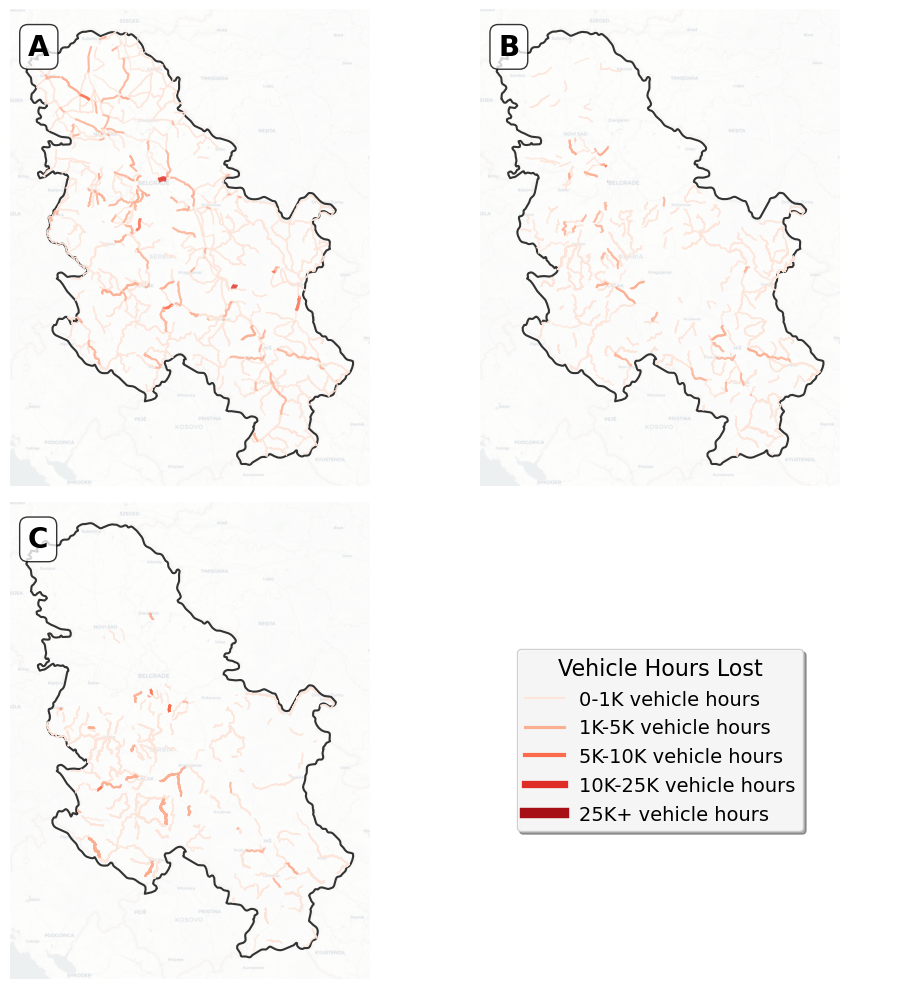

In [44]:
# Define bins and styling (shared across all three)
bins = [0, 1000, 5000, 10000, 25000, np.inf]
labels = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']
linewidth_map = {'0-1K': 1, '1K-5K': 1.5, '5K-10K': 2.0, '10K-25K': 3.5, '25K+': 5.0}

# Prepare all three datasets
datasets = {
    'A': ('Floods', gdf_vhl_flooded),
    'B': ('Snow Drift', gdf_vhl_snowdrift),
    'C': ('Landslides', gdf_vhl_landslides)
}

# Bin all datasets
for letter, (title, gdf) in datasets.items():
    gdf['vhl_class'] = pd.cut(gdf['vhl'], bins=bins, labels=labels, include_lowest=True)

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white')
axes = axes.flatten()  # Flatten to [ax_A, ax_B, ax_C, ax_legend]

# Convert country boundary once
serbia_mercator = country_plot.to_crs(3857)

# Plot the three hazard maps
for idx, (letter, (title, gdf)) in enumerate(datasets.items()):
    ax = axes[idx]
    gdf_mercator = gdf.to_crs(3857)
    
    # Plot country outline
    serbia_mercator.plot(ax=ax, facecolor='none', edgecolor='#333333', 
                         linewidth=1.5, zorder=1)
    
    # Plot each VHL class
    for i, (class_name, width) in enumerate(linewidth_map.items()):
        subset = gdf_mercator[gdf_mercator['vhl_class'] == class_name]
        if not subset.empty:
            subset.plot(ax=ax, color=colors[i], linewidth=width, alpha=0.8, zorder=2)
    
    # Add basemap
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, 
                   alpha=0.4, attribution=False)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add letter label
    ax.text(0.05, 0.95, f'{letter}', transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Use the 4th panel (lower right) for the legend
ax_legend = axes[3]
ax_legend.axis('off')

# Create legend elements
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=width * 1.5, label=f'{class_name} vehicle hours')
    for i, (class_name, width) in enumerate(linewidth_map.items())
]

# Add legend to the empty panel
ax_legend.legend(handles=legend_elements, 
                 title='Vehicle Hours Lost',
                 loc='center',
                 fontsize=14,
                 title_fontsize=16,
                 frameon=True,
                 fancybox=True,
                 shadow=True,
                 framealpha=0.9,
                 facecolor='white',
                 edgecolor='#cccccc')


plt.tight_layout()
plt.savefig('vhl_hazards_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# ============ BASELINE RESULTS ============
print("=" * 60)
print("BASELINE RESULTS - AVERAGE TIME DELAY")
print("=" * 60)

print(f"\nTotal road segments analyzed: {len(gdf_results):,}")
print(f"\nAverage Time Disruption (hours):")
print(gdf_hazards['average_time_disruption'].describe())

# Convert to minutes for interpretation
gdf_results['avg_delay_minutes'] = gdf_results['average_time_disruption'] * 60
print(f"\nAverage Time Disruption (minutes):")
print(gdf_results['avg_delay_minutes'].describe())

# Segments by delay category
print("\nSegments by delay category:")
delay_bins = [0, 0.01, 0.25, 0.5, 1, np.inf]
delay_labels = ['No Delay', '1-15 min', '15-30 min', '30-60 min', '60+ min']
gdf_results['delay_class'] = pd.cut(gdf_results['average_time_disruption'], 
                                     bins=delay_bins, labels=delay_labels, include_lowest=True)
print(gdf_results['delay_class'].value_counts().sort_index())
print("\nPercentages:")
print((gdf_results['delay_class'].value_counts(normalize=True).sort_index() * 100).round(2))

print("\n" + "=" * 60)
print("BASELINE RESULTS - VEHICLE HOURS LOST")
print("=" * 60)

print(f"\nTotal road segments: {len(gdf_results):,}")
print(f"\nVehicle Hours Lost (VHL):")
print(gdf_results['vhl'].describe())

print(f"\nTotal VHL across network: {gdf_results['vhl'].sum():,.0f} vehicle hours")
print(f"Mean VHL per segment: {gdf_results['vhl'].mean():,.2f} vehicle hours")
print(f"Median VHL per segment: {gdf_results['vhl'].median():,.2f} vehicle hours")

# Segments by VHL category
print("\nSegments by VHL category:")
vhl_bins = [0, 1000, 5000, 10000, 25000, np.inf]
vhl_labels = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
gdf_results['vhl_class'] = pd.cut(gdf_results['vhl'], bins=vhl_bins, labels=vhl_labels, include_lowest=True)
print(gdf_results['vhl_class'].value_counts().sort_index())
print("\nPercentages:")
print((gdf_results['vhl_class'].value_counts(normalize=True).sort_index() * 100).round(2))

# Top 10 most critical segments
print("\nTop 10 segments by VHL:")
print(gdf_results.nlargest(10, 'vhl')[['oznaka_deo', 'kategorija', 'vhl', 'total_aadt']].to_string())


# ============ HAZARD-SPECIFIC RESULTS ============
print("\n" + "=" * 60)
print("HAZARD-SPECIFIC RESULTS - VEHICLE HOURS LOST")
print("=" * 60)

hazard_datasets = {
    'Floods': gdf_vhl_flooded,
    'Snow Drift': gdf_vhl_snowdrift,
    'Landslides': gdf_vhl_landslides
}

# Summary comparison table
summary_data = []

for hazard_name, gdf in hazard_datasets.items():
    print(f"\n{'─' * 40}")
    print(f"{hazard_name.upper()}")
    print(f"{'─' * 40}")
    
    print(f"Affected road segments: {len(gdf):,}")
    print(f"\nVHL Statistics:")
    print(gdf_results['vhl'].describe())
    
    print(f"\nTotal VHL: {gdf_results['vhl'].sum():,.0f} vehicle hours")
    print(f"Mean VHL: {gdf_results['vhl'].mean():,.2f} vehicle hours")
    print(f"Median VHL: {gdf_results['vhl'].median():,.2f} vehicle hours")
    print(f"Max VHL: {gdf_results['vhl'].max():,.2f} vehicle hours")
    
    # By category
    gdf['vhl_class'] = pd.cut(gdf_results['vhl'], bins=vhl_bins, labels=vhl_labels, include_lowest=True)
    print(f"\nSegments by VHL category:")
    print(gdf['vhl_class'].value_counts().sort_index())
    
    # By road category if available
    if 'kategorija' in gdf_results.columns:
        print(f"\nVHL by road category:")
        print(gdf_results.groupby('kategorija')['vhl'].agg(['count', 'sum', 'mean']).round(2))
    
    # Top 5 critical segments
    print(f"\nTop 5 most critical segments:")
    cols_to_show = ['oznaka_deo', 'kategorija', 'vhl', 'total_aadt'] if 'total_aadt' in gdf_results.columns else ['oznaka_deo', 'kategorija', 'vhl']
    cols_to_show = [c for c in cols_to_show if c in gdf_results.columns]
    print(gdf_results.nlargest(5, 'vhl')[cols_to_show].to_string())
    
    # Collect for summary table
    summary_data.append({
        'Hazard': hazard_name,
        'Affected Segments': len(gdf_results),
        'Total VHL': gdf_results['vhl'].sum(),
        'Mean VHL': gdf_results['vhl'].mean(),
        'Median VHL': gdf_results['vhl'].median(),
        'Max VHL': gdf_results['vhl'].max(),
        'Segments >25K VHL': len(gdf_results[gdf_results['vhl'] >= 25000])
    })

# Create comparison summary table
print("\n" + "=" * 60)
print("HAZARD COMPARISON SUMMARY")
print("=" * 60)
summary_df = pd.DataFrame(summary_data)
summary_df['Total VHL'] = summary_df['Total VHL'].apply(lambda x: f"{x:,.0f}")
summary_df['Mean VHL'] = summary_df['Mean VHL'].apply(lambda x: f"{x:,.2f}")
summary_df['Median VHL'] = summary_df['Median VHL'].apply(lambda x: f"{x:,.2f}")
summary_df['Max VHL'] = summary_df['Max VHL'].apply(lambda x: f"{x:,.2f}")
print(summary_df.to_string(index=False))

# ============ ADDITIONAL ANALYSIS ============
print("\n" + "=" * 60)
print("ADDITIONAL ANALYSIS")
print("=" * 60)

# Which road categories are most affected by each hazard?
print("\nRoad categories most affected (by total VHL):")
for hazard_name, gdf in hazard_datasets.items():
    if 'kategorija' in gdf_results.columns:
        top_cat = gdf_results.groupby('kategorija')['vhl'].sum().sort_values(ascending=False)
        print(f"\n{hazard_name}:")
        print(top_cat)

# Overlap analysis - are the same segments affected by multiple hazards?
print("\n" + "─" * 40)
print("OVERLAP ANALYSIS")
print("─" * 40)

# Get unique segment identifiers (assuming 'oznaka_deo' or similar exists)
if 'oznaka_deo' in gdf_vhl_flooded.columns:
    flooded_segments = set(gdf_vhl_flooded['oznaka_deo'].dropna())
    snow_segments = set(gdf_vhl_snowdrift['oznaka_deo_left'].dropna())
    landslide_segments = set(gdf_vhl_landslides['oznaka_deo_left'].dropna())
    
    print(f"Segments affected by floods only: {len(flooded_segments - snow_segments - landslide_segments)}")
    print(f"Segments affected by snow only: {len(snow_segments - flooded_segments - landslide_segments)}")
    print(f"Segments affected by landslides only: {len(landslide_segments - flooded_segments - snow_segments)}")
    print(f"Segments affected by floods AND snow: {len(flooded_segments & snow_segments)}")
    print(f"Segments affected by floods AND landslides: {len(flooded_segments & landslide_segments)}")
    print(f"Segments affected by snow AND landslides: {len(snow_segments & landslide_segments)}")
    print(f"Segments affected by ALL three hazards: {len(flooded_segments & snow_segments & landslide_segments)}")

BASELINE RESULTS - AVERAGE TIME DELAY

Total road segments analyzed: 5,430

Average Time Disruption (hours):
count    1.992000e+03
mean     9.766418e-02
std      9.695612e-02
min      8.536134e-10
25%      3.087300e-02
50%      7.514485e-02
75%      1.325620e-01
max      8.247362e-01
Name: average_time_disruption, dtype: float64

Average Time Disruption (minutes):
count    4.387000e+03
mean     5.133587e+00
std      5.840554e+00
min      7.769114e-09
25%      7.196400e-01
50%      3.680703e+00
75%      7.127496e+00
max      4.948417e+01
Name: avg_delay_minutes, dtype: float64

Segments by delay category:
delay_class
No Delay     1065
1-15 min     3049
15-30 min     234
30-60 min      39
60+ min         0
Name: count, dtype: int64

Percentages:
delay_class
No Delay     24.28
1-15 min     69.50
15-30 min     5.33
30-60 min     0.89
60+ min       0.00
Name: proportion, dtype: float64

BASELINE RESULTS - VEHICLE HOURS LOST

Total road segments: 5,430

Vehicle Hours Lost (VHL):
count     35